In [1]:
# Import necessary modules
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import seaborn as sns 
import os
import sys
import time
import math
import re
import string
from bs4 import BeautifulSoup
import pickle
import joblib
from joblib import dump, load

import nltk as nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import spacy 
from spacy import displacy
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from pprint import pprint
import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

from bertopic import BERTopic
import torch
import tensorflow as tf
import ipywidgets

from pandarallel import pandarallel
import multiprocessing
from multiprocessing import Pool

import warnings
warnings.filterwarnings(action = 'ignore', category = UserWarning, module = 'gensim')

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
%matplotlib inline

2023-05-26 23:07:11.152884: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-26 23:07:13.808457: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-26 23:07:13.808582: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/

In [2]:
num_processors = multiprocessing.cpu_count()
workers = num_processors-1
print(f'Available CPUs: {num_processors}')

Available CPUs: 96


In [3]:
pandarallel.initialize(progress_bar=True, nb_workers=num_processors-4, use_memory_fs=False)

INFO: Pandarallel will run on 92 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [4]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jupyter/nltk_data...


True

In [5]:
%%time
news_df = pd.read_parquet('https://storage.googleapis.com/msca-bdp-data-open/news_final_project/news_final_project.parquet', 
                     engine = 'pyarrow')
news_df.shape

CPU times: user 6.35 s, sys: 4.13 s, total: 10.5 s
Wall time: 19.6 s


(200332, 5)

In [6]:
news_df.head(2)

,url,date,language,title,text
0,http://en.people.cn/n3/2021/0318/c90000-9830122.html,2021-03-18,en,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online,\n\nArtificial intelligence improves parking efficiency in Chinese cities - People's Daily Onlin...
1,http://newsparliament.com/2020/02/27/children-with-autism-saw-their-learning-and-social-skills-b...,2020-02-27,en,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Rob...,\nChildren With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI R...


In [7]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200332 entries, 0 to 200331
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   url       200332 non-null  object
 1   date      200332 non-null  object
 2   language  200332 non-null  object
 3   title     200332 non-null  object
 4   text      200332 non-null  object
dtypes: object(5)
memory usage: 7.6+ MB


In [8]:
news_df['date'] = pd.to_datetime(news_df['date'])

In [9]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200332 entries, 0 to 200331
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   url       200332 non-null  object        
 1   date      200332 non-null  datetime64[ns]
 2   language  200332 non-null  object        
 3   title     200332 non-null  object        
 4   text      200332 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 7.6+ MB


In [10]:
df = news_df.copy()

# Removing noise
def remove_noise(text):
    # Removing newlines and tabs
    text = text.replace('\n|\t', ' ')

    # Removing remnants of web crawls and irrelevant text
    web_crawls = ['web crawl', 'click here', 'visit our website']
    for crawl in web_crawls:
        text = re.sub(r'\b{}\b'.format(crawl), '', text, flags=re.IGNORECASE)
    
    # Removing extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Removing web crawls
def remove_web_crawls(text):
    soup = BeautifulSoup(text, 'html.parser')
    for elem in soup.find_all():
        elem.extract()
    return soup.get_text()

In [11]:
%%time
# Apply the functions to the 'title' and 'text' column
df['clean_title'] = df['title'].parallel_apply(remove_noise)
df['clean_title'] = df['clean_title'].parallel_apply(remove_web_crawls)

df['clean_text'] = df['text'].parallel_apply(remove_noise)
df['clean_text'] = df['clean_text'].parallel_apply(remove_web_crawls)

CPU times: user 16.9 s, sys: 35.3 s, total: 52.2 s
Wall time: 49.1 s


In [12]:
# Filtering to keep articles in English
df = df[df['language'] == 'en']
df = df.drop(['url', 'language', 'title', 'text'], axis = 1)

In [13]:
# # Removing duplicate text
# df = df.drop_duplicates(subset = ['clean_text'], keep = 'first')
# df.shape[0]

In [14]:
# Keeping only relevant articles and discarding irrelevant ones
keywords = ['data science', 'artificial intelligence', 'machine learning', 'chatgpt', 'large language models', 'deep learning', 'engineering', 'software', 
            'big data', 'data analysis', 'neural networks', 'natural language processing', 'NLP', 'conversational ai', 'reinforcement learning', 
            'chatbot', 'transformer', 'ai', 'ml', 'technology']

# Filter based on keywords
df = df[df['clean_text'].str.contains('|'.join(keywords), case=False)]
df = df.reset_index(drop=True)

In [15]:
df.head()

,date,clean_title,clean_text
0,2021-03-18,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online Ho...
1,2020-02-27,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Rob...,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Rob...
2,2021-03-26,"Forget ML, AI and Industry 4.0 – obsolescence should be your focus - 26 February 2021 - Test & R...","Forget ML, AI and Industry 4.0 – obsolescence should be your focus - 26 February 2021 - Test & R..."
3,2021-03-10,Strategy Analytics: 71% of Smartphones Sold Globally in 2021 will be AI Powered – Consumer Elect...,Strategy Analytics: 71% of Smartphones Sold Globally in 2021 will be AI Powered – Consumer Elect...
4,2020-10-20,Olympus to Support Endoscopic AI Diagnosis Education for Doctors in India and to Launch AI Diagn...,Olympus to Support Endoscopic AI Diagnosis Education for Doctors in India and to Launch AI Diagn...


# Sentiment Analysis

Using VADER (Valence Aware Dictionary and sEntiment Reasoner). VADER is a rule-based sentiment analysis tool specifically designed for analyzing sentiment in social media text.

In [16]:
# Create an instance of the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [17]:
df_sia = df.copy()

In [18]:
# Applying sentiment analysis on title
df_sia['sentiment_score'] = df_sia['clean_title'].parallel_apply(lambda x: sia.polarity_scores(x))

In [19]:
df_sia.head()

,date,clean_title,clean_text,sentiment_score
0,2021-03-18,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online Ho...,"{'neg': 0.0, 'neu': 0.488, 'pos': 0.512, 'compound': 0.8126}"
1,2020-02-27,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Rob...,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Rob...,"{'neg': 0.0, 'neu': 0.788, 'pos': 0.212, 'compound': 0.5106}"
2,2021-03-26,"Forget ML, AI and Industry 4.0 – obsolescence should be your focus - 26 February 2021 - Test & R...","Forget ML, AI and Industry 4.0 – obsolescence should be your focus - 26 February 2021 - Test & R...","{'neg': 0.097, 'neu': 0.816, 'pos': 0.087, 'compound': -0.0516}"
3,2021-03-10,Strategy Analytics: 71% of Smartphones Sold Globally in 2021 will be AI Powered – Consumer Elect...,Strategy Analytics: 71% of Smartphones Sold Globally in 2021 will be AI Powered – Consumer Elect...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
4,2020-10-20,Olympus to Support Endoscopic AI Diagnosis Education for Doctors in India and to Launch AI Diagn...,Olympus to Support Endoscopic AI Diagnosis Education for Doctors in India and to Launch AI Diagn...,"{'neg': 0.0, 'neu': 0.779, 'pos': 0.221, 'compound': 0.6597}"


In [20]:
# Analyzing the average change in sentiment on a month-by-month basis
df_sia.set_index('date', inplace = True)
df_sia['compound_score'] = df_sia['sentiment_score'].parallel_apply(lambda x: x['compound'])
monthly_sentiment = df_sia['compound_score'].resample('M').mean()
start_date = df_sia.index.min().to_period('M').to_timestamp()
end_date = df_sia.index.max().to_period('M').to_timestamp()
monthly_dates = pd.date_range(start=start_date, end=end_date + pd.offsets.MonthEnd(1), freq='M')

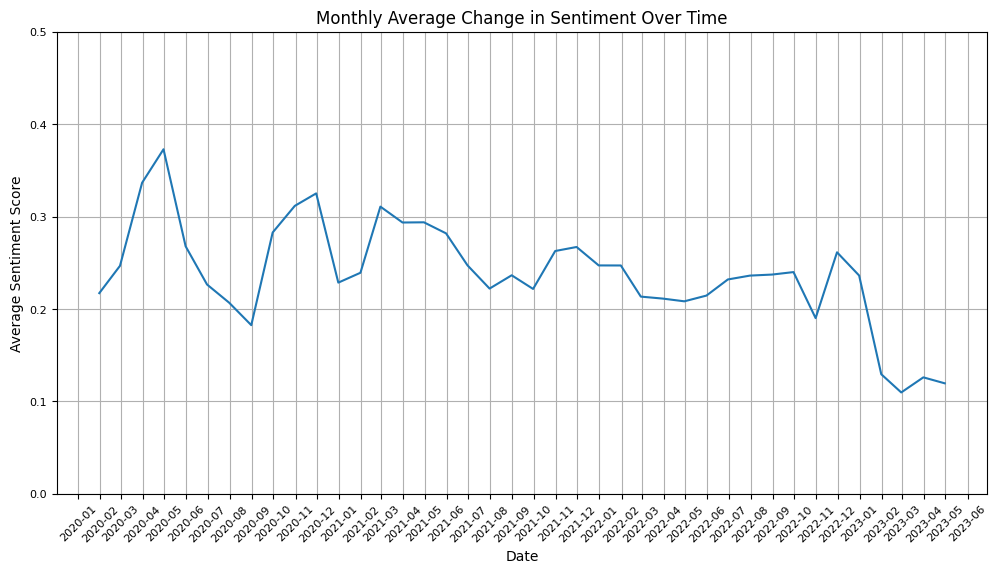

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_dates, monthly_sentiment)
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.title('Monthly Average Change in Sentiment Over Time')
plt.ylim(0, 0.5)
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.show()

In [22]:
# Function to label sentiment based on compound score
def label_sentiment(score):
    if score > 0.3:
        return 'Positive'
    elif score < -0.3:
        return 'Negative'
    else:
        return 'Neutral'

In [23]:
df_sia['sentiment'] = df_sia['compound_score'].parallel_apply(lambda x: label_sentiment(x))

In [24]:
# Creating a dataframe with articles whose sentiment is positive
pos_sia = df_sia[df_sia['sentiment'] == 'Positive']
pos_sia = pos_sia.drop(['sentiment_score'], axis = 1)

In [25]:
# Creating a dataframe with articles whose sentiment is negative
neg_sia = df_sia[df_sia['sentiment'] == 'Negative']
neg_sia = neg_sia.drop(['sentiment_score'], axis = 1)

In [26]:
# Creating a dataframe with articles whose sentiment is neutral
neutral_sia = df_sia[df_sia['sentiment'] == 'Neutral']
neutral_sia = neutral_sia.drop(['sentiment_score'], axis = 1)

In [27]:
# Define data
neg_count = len(neg_sia)
neutral_count = len(neutral_sia)
pos_count = len(pos_sia)
title = ['Negative', 'Neutral', 'Positive']
val = [neg_count, neutral_count, pos_count]
colors = ['red', 'blue', 'green']
explode = (0.1, 0, 0)
total = sum(val)

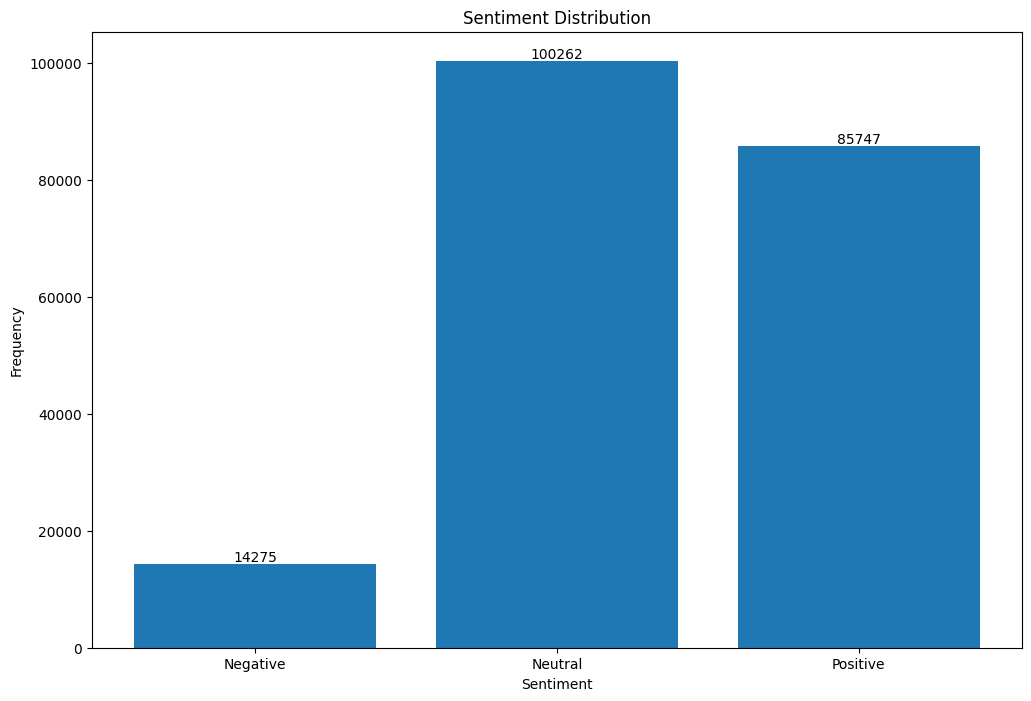

In [28]:
order = ['Negative', 'Neutral', 'Positive']
sentiment_counts = [neg_count, neutral_count, pos_count]
plt.figure(figsize=(12, 8))
plt.bar(order, sentiment_counts)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
for i, count in enumerate(sentiment_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')
plt.show()

In [29]:
# Define formatter for autopct
def my_fmt(x):
    return '{:.1f}%'.format(x)

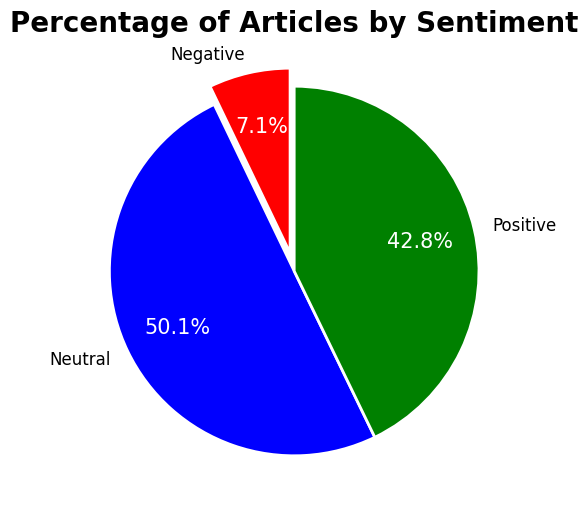

In [30]:
# Create pie chart using seaborn
fig, ax = plt.subplots(figsize=(10, 6))
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
patches, texts, autotexts = ax.pie(val, colors=colors, labels=title, autopct=my_fmt, startangle=90, explode=explode, pctdistance=0.7, 
                                   labeldistance=1.1, textprops={'fontsize': 12, 'color': 'black'}, wedgeprops={'linewidth': 2, 'edgecolor': 'white'})
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(15)
ax.set_title('Percentage of Articles by Sentiment', fontsize=20, fontweight='bold')
plt.show()

As we can see, there are six times more positive articles than negative articles.
One reason for this could be that the sentiment analyzer is biased. 
Default sentiment will likely be wrong from any software package and will require some tweaking
- Keyword / dictionary approach
- Data annotation and development of custom classifier
- Building custom model on open-source data (i.e. Yelp)
- Fine-tuning Transformer Pipeline

## Building a custom model on open-source data (i.e. Yelp) to analyze sentiment more accurately. 

In [31]:
directory = 'https://storage.googleapis.com/msca-bdp-data-open/yelp/'
fileName = 'yelp_train_sentiment.json'

path = directory + fileName

In [32]:
%%time
df_pipeline = pd.read_json(path, orient='records', lines=True)
df_pipeline.shape

CPU times: user 1.42 s, sys: 777 ms, total: 2.2 s
Wall time: 3.45 s


(255717, 3)

In [33]:
df_pipeline.head()

,text,label,lang
0,I love Deagan's. I do. I really do. The atmosphere is cozy and festive. The shrimp tacos and hou...,1,en
1,I love the classes at this gym. Zumba and. Radio Hip Hop are my favorite. This is such a great f...,1,en
2,The tables and floor were dirty. I was the only customer on a Saturday nite and the person work...,0,en
3,"I had an oil change at the 15515 N Scottsdale Road location. When the car was delivered to me, ...",0,en
4,The absolute WORST apartment complex I have ever lived in. Moved here from out of state. Hoped t...,0,en


In [34]:
X = df_pipeline['text']
y = df_pipeline['label']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, train_size=0.85, test_size=0.15)
print(f"Training records, X_train: {X_train.shape} y_train: {y_train.shape}")
print(f"Testing records, X_test: {X_test.shape} y_test: {y_test.shape}")

Training records, X_train: (217359,) y_train: (217359,)
Testing records, X_test: (38358,) y_test: (38358,)


### Training a Logistic Regression Model on Yelp Reviews Data

In [36]:
pipe_logreg = make_pipeline(
    TfidfVectorizer(lowercase=False, stop_words='english', ngram_range=(1, 3)),
    LogisticRegression(max_iter=1000)
)

In [37]:
%%time
pipe_logreg.fit(X_train, y_train)

CPU times: user 24min 7s, sys: 23min 25s, total: 47min 32s
Wall time: 5min 3s


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(lowercase=False, ngram_range=(1, 3),
                                 stop_words='english')),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [38]:
# make class predictions
y_pred_logreg = pipe_logreg.predict(X_test)

In [39]:
# calculate accuracy of class predictions
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_logreg) * 100:.1f}%")

Test Accuracy: 96.7%


In [40]:
# calculate precision and recall
print(classification_report(y_test, y_pred_logreg))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97     19199
           1       0.97      0.96      0.97     19159

    accuracy                           0.97     38358
   macro avg       0.97      0.97      0.97     38358
weighted avg       0.97      0.97      0.97     38358



In [41]:
# calculate the confusion matrix
print(confusion_matrix(y_test, y_pred_logreg))

[[18612   587]
 [  691 18468]]


In [42]:
%%time 
dump(pipe_logreg, "logreg.joblib")

CPU times: user 1min 16s, sys: 2.89 s, total: 1min 19s
Wall time: 1min 19s


['logreg.joblib']

In [43]:
df_yelp_sentiment = df.copy()

In [44]:
test = df_yelp_sentiment['clean_title']
y_pred = pipe_logreg.predict(test)

In [45]:
df_yelp_sentiment['sentiment'] = y_pred
df_yelp_sentiment['sentiment_category'] = df_yelp_sentiment['sentiment'].map({0: 'Negative', 1: 'Positive'})

In [46]:
df_yelp_sentiment.head()

,date,clean_title,clean_text,sentiment,sentiment_category
0,2021-03-18,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online Ho...,1,Positive
1,2020-02-27,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Rob...,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Rob...,0,Negative
2,2021-03-26,"Forget ML, AI and Industry 4.0 – obsolescence should be your focus - 26 February 2021 - Test & R...","Forget ML, AI and Industry 4.0 – obsolescence should be your focus - 26 February 2021 - Test & R...",0,Negative
3,2021-03-10,Strategy Analytics: 71% of Smartphones Sold Globally in 2021 will be AI Powered – Consumer Elect...,Strategy Analytics: 71% of Smartphones Sold Globally in 2021 will be AI Powered – Consumer Elect...,0,Negative
4,2020-10-20,Olympus to Support Endoscopic AI Diagnosis Education for Doctors in India and to Launch AI Diagn...,Olympus to Support Endoscopic AI Diagnosis Education for Doctors in India and to Launch AI Diagn...,0,Negative


In [47]:
df_pos = df_yelp_sentiment[df_yelp_sentiment['sentiment_category']=='Positive'][["date", "clean_title", "clean_text", "sentiment", "sentiment_category"]]
df_pos.head(2)

,date,clean_title,clean_text,sentiment,sentiment_category
0,2021-03-18,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online Ho...,1,Positive
6,2020-12-08,From the Bard to broadcaster: Stratford Festival builds new identity with streamer | National En...,From the Bard to broadcaster: Stratford Festival builds new identity with streamer | National En...,1,Positive


In [48]:
df_pos.to_csv("positive_articles_yelp.csv", index=False)

In [49]:
df_neg = df_yelp_sentiment[df_yelp_sentiment['sentiment_category']=='Negative'][["date", "clean_title", "clean_text", "sentiment", "sentiment_category"]]
df_neg.head(2)

,date,clean_title,clean_text,sentiment,sentiment_category
1,2020-02-27,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Rob...,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Rob...,0,Negative
2,2021-03-26,"Forget ML, AI and Industry 4.0 – obsolescence should be your focus - 26 February 2021 - Test & R...","Forget ML, AI and Industry 4.0 – obsolescence should be your focus - 26 February 2021 - Test & R...",0,Negative


In [50]:
df_neg.to_csv("negative_articles_yelp.csv", escapechar='\\', index=False)

In [51]:
# Analyzing the average change in sentiment on a month-by-month basis
df_sentiment_change = df_yelp_sentiment.copy()
df_sentiment_change.set_index('date', inplace = True)
monthly_sentiment = df_sentiment_change['sentiment'].resample('M').mean()
start_date = df_sentiment_change.index.min().to_period('M').to_timestamp()
end_date = df_sentiment_change.index.max().to_period('M').to_timestamp()
monthly_dates = pd.date_range(start=start_date, end=end_date + pd.offsets.MonthEnd(1), freq='M')

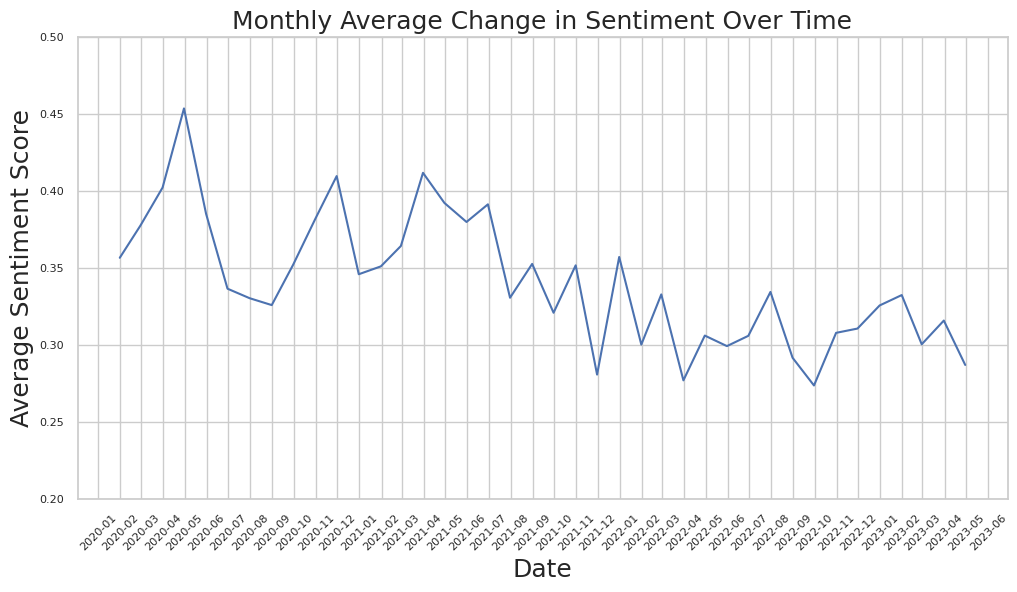

In [52]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_dates, monthly_sentiment)
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.title('Monthly Average Change in Sentiment Over Time')
plt.ylim(0.2, 0.5)
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.show()

In [53]:
# Define data
neg_count = len(df_neg)
pos_count = len(df_pos)
title = ['Negative', 'Positive']
val = [neg_count, pos_count]
colors = ['red', 'green']
explode = (0.1, 0)
total = sum(val)

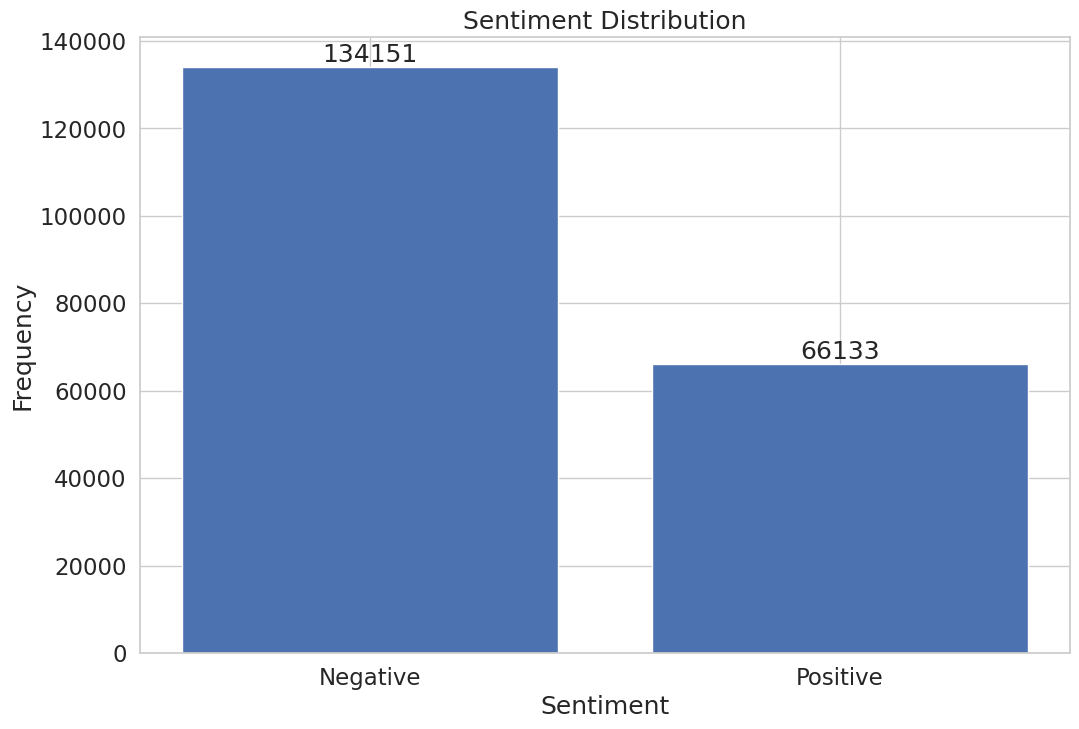

In [54]:
order = ['Negative', 'Positive']
sentiment_counts = [neg_count, pos_count]
plt.figure(figsize=(12, 8))
plt.bar(order, sentiment_counts)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
for i, count in enumerate(sentiment_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')
plt.show()

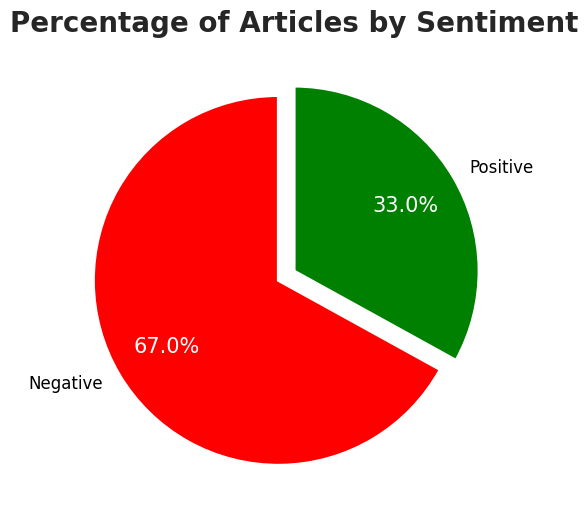

In [55]:
# Create pie chart using seaborn
fig, ax = plt.subplots(figsize=(10, 6))
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
patches, texts, autotexts = ax.pie(val, colors=colors, labels=title, autopct=my_fmt, startangle=90, explode=explode, pctdistance=0.7, 
                                   labeldistance=1.1, textprops={'fontsize': 12, 'color': 'black'}, wedgeprops={'linewidth': 2, 'edgecolor': 'white'})
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(15)
ax.set_title('Percentage of Articles by Sentiment', fontsize=20, fontweight='bold')
plt.show()

As we can see above, the average monthly change in sentiment over time is somehwat similar with both approaches. 

However, the custom sentiment analyzer pipeline (trained on Yelp data) does not categorize any article as neutral. 

Additionally, the ratio of negative articles to positive articles is now 2 is to 3. Most of the neutral articles are now categorized as negative while some are categorized as positive. 

This is the trade-off between using a default sentiment package (VADER) versus a custom built pipeline trained on data from Yelp reviews.

# Detecting Major Topics

In [56]:
# !python -m spacy download en_core_web_sm
# !python -m spacy download en_core_web_md
!python -m spacy download en_core_web_lg
# !python -m spacy download en_core_web_trf

2023-05-26 23:20:22.742691: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-26 23:20:25.519250: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-26 23:20:25.519372: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/

In [57]:
# Load SpaCy model
# nlp = spacy.load('en_core_web_sm')
# nlp = spacy.load('en_core_web_md')
nlp = spacy.load('en_core_web_lg')
# nlp = spacy.load('en_core_web_trf')

In [58]:
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

## Named Entity Recognition

For articles with a negative sentiment

In [59]:
# Removing stopwords and punctuation from text
def clean_news_articles(text):
    # Tokenize
    words = nltk.tokenize.word_tokenize(text)
    
    # Remove single-character tokens (mostly punctuation)
    words = [word for word in words if len(word) > 1]
    
    # Remove punctuation
    words = [word.lower() for word in words if word.isalpha()]

    # Remove stopwords
    words = [word for word in words if word not in stopwords]
    return " ".join(words)

In [60]:
df_neg_clean = df_neg.copy()

In [61]:
%%time
# Removing stopwords and punctuation from title
stopwords = set(nltk.corpus.stopwords.words('english'))
df_neg_clean['clean_title'] = df_neg_clean['clean_title'].parallel_apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
df_neg_clean['clean_title'] = df_neg_clean['clean_title'].parallel_apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

CPU times: user 1.97 s, sys: 26.3 s, total: 28.3 s
Wall time: 27.6 s


In [62]:
%%time
df_neg_clean['clean_text'] = df_neg_clean['clean_text'].parallel_apply(clean_news_articles)

CPU times: user 9.65 s, sys: 24.2 s, total: 33.8 s
Wall time: 39.9 s


In [63]:
df_neg_clean.head(2)

,date,clean_title,clean_text,sentiment,sentiment_category
1,2020-02-27,Children With Autism Saw Their Learning Social Skills Boosted After Playing With This AI Robot –...,children autism saw learning social skills boosted playing ai robot news parliament skip content...,0,Negative
2,2021-03-26,Forget ML AI Industry 40 – obsolescence focus 26 February 2021 Test Rework Solutions Dataweek,forget ml ai industry obsolescence focus february test rework solutions dataweek home us back is...,0,Negative


In [64]:
# def perform_ner(df, column):
#     entities = []
#     labels = []
#     position_start = []
#     position_end = []
#     for line in df[column]:
#         doc = nlp(line)
#         for ent in doc.ents:
#             entities.append(ent.text)
#             labels.append(ent.label_)
#             position_start.append(ent.start_char)
#             position_end.append(ent.end_char)
#     df_spacy_custom = pd.DataFrame({'Entities': entities, 'Labels': labels,
#                                     'Position_Start': position_start, 'Position_End': position_end})
#     return df_spacy_custom

In [65]:
# %%time
# df_neg_spacy = perform_ner(df_neg_clean, 'clean_text')
# df_neg_spacy

In [66]:
# def NER_SpaCy(text):
#     doc = nlp(text)
#     entities = []
#     labels = []
#     position_start = []
#     position_end = []
#     for ent in doc.ents:
#         entities.append(ent.text)
#         labels.append(ent.label_)
#         position_start.append(ent.start_char)
#         position_end.append(ent.end_char)
#     df = pd.DataFrame({"Entities": entities, "Labels": labels, 
#                        "Position_Start": position_start, "Position_End": position_end})
#     return df

In [67]:
# %%time
# neg_clean_text = ' '.join(df_neg_clean['clean_text'])

In [68]:
# nlp.max_length = len(neg_clean_text)

In [69]:
# %%time
# df_neg_spacy = NER_SpaCy(neg_clean_text)
# df_neg_spacy.head()

In [70]:
skip_list = ['Data Science', 'data science', 'DATA SCIENCE', 'AI', 'ai', 'artificial intelligence', 'Artificial Intelligence', 'ARTIFICIAL INTELLIGENCE', 'ML', 'NLP', 
             'Artificial General Intelligence', 'Chatbots', 'AI Marketplaces', 'Intelligent Applications', 'Augmented Intelligence', 'Decision Intelligence', 
             'AI Cloud Services', 'cloud services', 'GPU Accelerators', 'Computer Vision', 'Deep Neural Network', 'Deep Learning', 'Cognitive Computing', 
             'Autonomous Vehicles', 'Knowledge Graphs', 'Responsible AI', 'Machine Customers', 'Decision Intelligence', 'Autonomous Vehicles', 'Human-Centered AI', 
             'AI Governance', 'Natural Language Processing', 'Machine Learning', 'Smart Robots', 'Operational AI Systems', 'Data-Centric AI', 'AI TRiSM', 
             'Generative AI', 'Responsible AI']

In [71]:
def process_line(line):
    doc = nlp(line)
    entities = []
    labels = []
    position_start = []
    position_end = []
    for ent in doc.ents:
        entities.append(ent.text)
        labels.append(ent.label_)
        position_start.append(ent.start_char)
        position_end.append(ent.end_char)
    return entities, labels, position_start, position_end

def perform_ner_parallel(df, column, nlp):
    lines = df[column].tolist()
    with Pool() as pool:
        results = pool.map(process_line, lines)
    entities = []
    labels = []
    position_start = []
    position_end = []
    for res in results:
        entities.extend(res[0])
        labels.extend(res[1])
        position_start.extend(res[2])
        position_end.extend(res[3])
    df_spacy_custom = pd.DataFrame({'Entities': entities, 'Labels': labels,
                                    'Position_Start': position_start, 'Position_End': position_end})
    return df_spacy_custom

In [72]:
%%time
df_neg_spacy = perform_ner_parallel(df_neg_clean, 'clean_text', nlp)

CPU times: user 16.2 s, sys: 28.9 s, total: 45.2 s
Wall time: 5min 52s


In [73]:
df_neg_spacy.head()

,Entities,Labels,Position_Start,Position_End
0,thursday,DATE,97,105
1,february,DATE,106,114
2,drax power,ORG,161,171
3,overnight,TIME,231,240
4,italy,GPE,246,251


In [74]:
# Extracting PERSON labels

In [75]:
person_text_SpaCy = df_neg_spacy[df_neg_spacy['Labels'] == 'PERSON']
frequency_text_SpaCy = person_text_SpaCy.groupby('Entities').count()
frequency_text_SpaCy = frequency_text_SpaCy.drop(['Position_Start', 'Position_End'], axis = 1)
frequency_text_SpaCy.rename(columns = {'Labels': 'Mentions'}, inplace = True) 
frequency_text_SpaCy.sort_values(by = ['Mentions'], ascending = False).head(20)

,Mentions
Entities,
baidu,5685
greta van susterencircle country,4750
joe biden,4514
biden,4218
donald trump,3831
metv,3485
freddy,3300
norge polska,2943
sam altman,2938


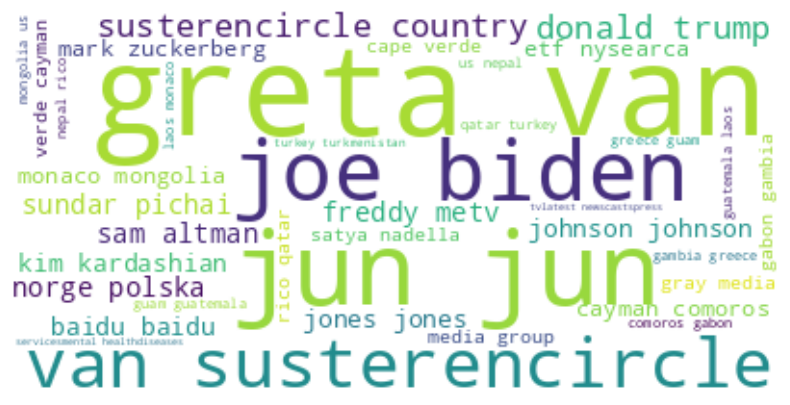

In [76]:
text = ' '.join(entities for entities in person_text_SpaCy.Entities)

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(skip_list)

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color='white').generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize = (10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [77]:
# Extracting LOCATION labels

In [78]:
location_text_SpaCy = df_neg_spacy[df_neg_spacy['Labels'] == 'LOC']
frequency_text_SpaCy = location_text_SpaCy.groupby('Entities').count()
frequency_text_SpaCy = frequency_text_SpaCy.drop(['Position_Start', 'Position_End'], axis = 1)
frequency_text_SpaCy.rename(columns = {'Labels': 'Mentions'}, inplace = True) 
frequency_text_SpaCy.sort_values(by = ['Mentions'], ascending = False).head(20)

,Mentions
Entities,
europe,27856
north america,11263
asia,8121
lehigh valley,6414
latin america,6200
middle east,4530
africa,3338
south america,3047
asia pacific,2387


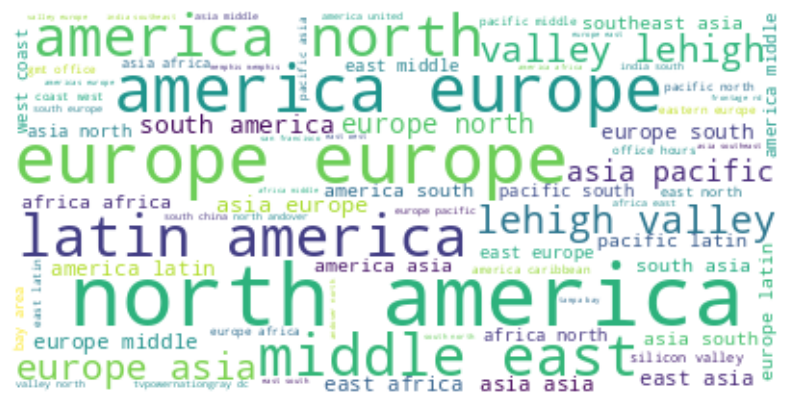

In [79]:
text = ' '.join(entities for entities in location_text_SpaCy.Entities)

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(skip_list)

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color='white').generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize = (10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [80]:
# Extracting ORGANIZATION labels

In [81]:
organization_text_SpaCy = df_neg_spacy[df_neg_spacy['Labels'] == 'ORG']
frequency_text_SpaCy = organization_text_SpaCy.groupby('Entities').count()
frequency_text_SpaCy = frequency_text_SpaCy.drop(['Position_Start', 'Position_End'], axis = 1)
frequency_text_SpaCy.rename(columns = {'Labels': 'Mentions'}, inplace = True) 
frequency_text_SpaCy.sort_values(by = ['Mentions'], ascending = False).head(20)

,Mentions
Entities,
chatgpt,126971
microsoft,32255
ibm,32029
gray television inc,31090
gray media group,30395
courtesy prnewswire views opinions,30353
fcc,26555
rss,24366
google,19352


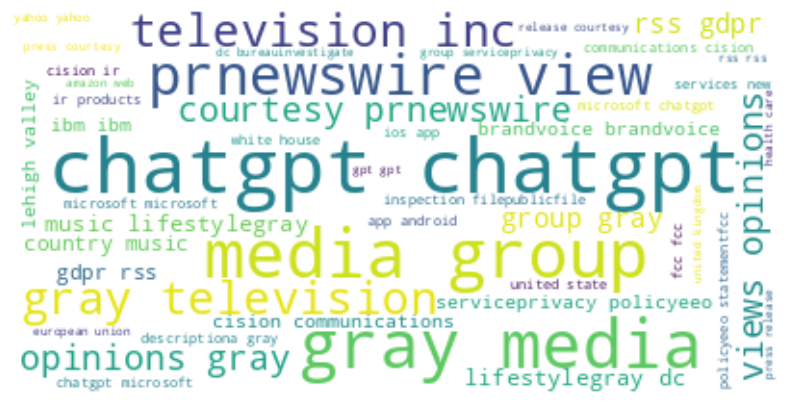

In [82]:
text = ' '.join(entities for entities in organization_text_SpaCy.Entities)

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(skip_list)
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color='white').generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize = (10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

For articles with a positive sentiment

In [83]:
df_pos_clean = df_pos.copy()

In [84]:
%%time
df_pos_clean['clean_title'] = df_pos_clean['clean_title'].parallel_apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
df_pos_clean['clean_title'] = df_pos_clean['clean_title'].parallel_apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

CPU times: user 2.68 s, sys: 37.5 s, total: 40.2 s
Wall time: 38.5 s


In [85]:
%%time
df_pos_clean['clean_text'] = df_pos_clean['clean_text'].parallel_apply(clean_news_articles)

CPU times: user 5.21 s, sys: 25.8 s, total: 31 s
Wall time: 33.7 s


In [86]:
df_pos_clean.head(2)

,date,clean_title,clean_text,sentiment,sentiment_category
0,2021-03-18,Artificial intelligence improves parking efficiency Chinese cities Peoples Daily Online,artificial intelligence improves parking efficiency chinese cities people daily online home chin...,1,Positive
6,2020-12-08,From Bard broadcaster Stratford Festival builds new identity streamer National Entertainment p...,bard broadcaster stratford festival builds new identity streamer national entertainment permissi...,1,Positive


In [87]:
# %%time
# df_pos_spacy = perform_ner(df_pos_clean, 'clean_text')
# df_pos_spacy

In [88]:
# %%time
# pos_clean_text = ' '.join(df_pos_clean['clean_text'])

In [89]:
# nlp.max_length = len(pos_clean_text)

In [90]:
# %%time
# df_pos_spacy = NER_SpaCy(pos_clean_text)
# df_pos_spacy.head()

In [91]:
%%time
df_pos_spacy = perform_ner_parallel(df_pos_clean, 'clean_text', nlp)

CPU times: user 9.45 s, sys: 31.1 s, total: 40.6 s
Wall time: 3min 15s


In [92]:
df_pos_spacy.head()

,Entities,Labels,Position_Start,Position_End
0,chinese,NORP,52,59
1,daily,DATE,74,79
2,china,GPE,92,97
3,china business military world society culture travel science,ORG,138,198
4,chinese,NORP,222,229


In [93]:
# Extracting PERSON labels

In [94]:
person_text_SpaCy = df_pos_spacy[df_pos_spacy['Labels'] == 'PERSON']
frequency_text_SpaCy = person_text_SpaCy.groupby('Entities').count()
frequency_text_SpaCy = frequency_text_SpaCy.drop(['Position_Start', 'Position_End'], axis = 1)
frequency_text_SpaCy.rename(columns = {'Labels': 'Mentions'}, inplace = True) 
frequency_text_SpaCy.sort_values(by = ['Mentions'], ascending = False).head(20)

,Mentions
Entities,
baidu,2890
greta van susterencircle country,1993
biden,1763
joe biden,1577
norge polska,1568
bfsi,1494
tom,1430
don,1349
kim kardashian,1274


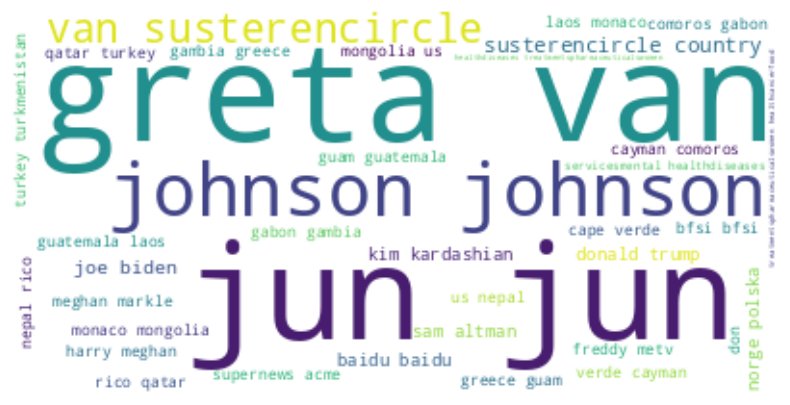

In [95]:
text = ' '.join(entities for entities in person_text_SpaCy.Entities)

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(skip_list)

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color='white').generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize = (10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [96]:
# Extracting LOCATION labels

In [97]:
location_text_SpaCy = df_pos_spacy[df_pos_spacy['Labels'] == 'LOC']
frequency_text_SpaCy = location_text_SpaCy.groupby('Entities').count()
frequency_text_SpaCy = frequency_text_SpaCy.drop(['Position_Start', 'Position_End'], axis = 1)
frequency_text_SpaCy.rename(columns = {'Labels': 'Mentions'}, inplace = True) 
frequency_text_SpaCy.sort_values(by = ['Mentions'], ascending = False).head(20)

,Mentions
Entities,
europe,20371
north america,9736
asia,5551
latin america,5392
south america,4151
north america europe,2978
middle east,2575
asia pacific,2362
middle east africa,1926


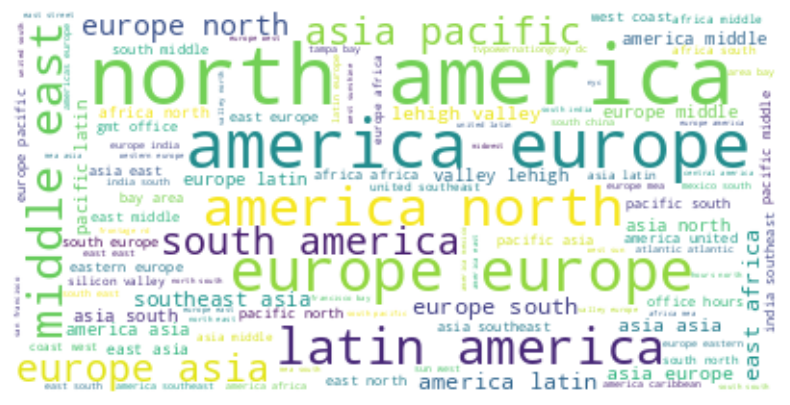

In [98]:
text = ' '.join(entities for entities in location_text_SpaCy.Entities)

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(skip_list)
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color='white').generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize = (10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [99]:
# Extracting ORGANIZATION labels

In [100]:
organization_text_SpaCy = df_pos_spacy[df_pos_spacy['Labels'] == 'ORG']
frequency_text_SpaCy = organization_text_SpaCy.groupby('Entities').count()
frequency_text_SpaCy = frequency_text_SpaCy.drop(['Position_Start', 'Position_End'], axis = 1)
frequency_text_SpaCy.rename(columns = {'Labels': 'Mentions'}, inplace = True) 
frequency_text_SpaCy.sort_values(by = ['Mentions'], ascending = False).head(20)

,Mentions
Entities,
chatgpt,48428
ibm,26091
gray television inc,13710
gray media group,13498
courtesy prnewswire views opinions,13473
microsoft,12781
rss,11317
fcc,9289
rss gdpr,9004


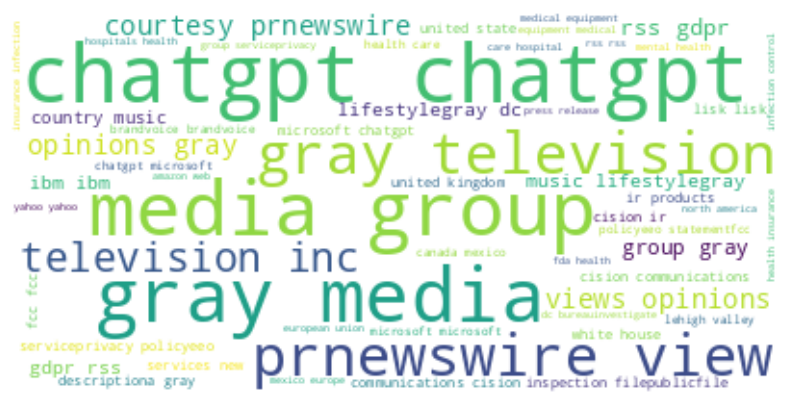

In [101]:
text = ' '.join(entities for entities in organization_text_SpaCy.Entities)

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(skip_list)
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color='white').generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize = (10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [102]:
df.to_parquet('df.parquet', engine='pyarrow')

In [103]:
df_yelp_sentiment.to_parquet('df_yelp_sentiment.parquet', engine='pyarrow')

In [104]:
df_pos_clean.to_parquet("df_pos.parquet", engine='pyarrow')

In [105]:
df_neg_clean.to_parquet("df_neg.parquet", engine='pyarrow')

In [106]:
df_pos_spacy.to_csv("positive_spacy.csv", index=False)

In [107]:
df_neg_spacy.to_csv("negative_spacy.csv", index=False)